In [2]:
import pyro
import torch
import numpy as np

import pyro.distributions as dist


from pyro.infer import MCMC, NUTS 
from pyro.poutine import reparam,condition,trace,seed

from typing import OrderedDict
import matplotlib.pyplot as plt

import VIPReparam

from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoNormal
from pyro.optim import Adam

In [19]:
def neal_funnel(obs : torch.Tensor, noise = 0.1):
    with pyro.plate("obs_batch",obs.shape[1]):
        x = pyro.sample("x",dist.Normal(0,1))
        y = pyro.sample("y",dist.Normal(0,torch.exp(x)))
        with pyro.plate("obs_num",obs.shape[0]):
            pyro.sample("obs", dist.Normal(y,noise),obs=obs)
        

In [26]:
model = neal_funnel
obs_t = torch.transpose(torch.tensor([[1,1,1],[1,1,1]]),0,1)
print(trace(model).get_trace(obs_t).format_shapes())

 Trace Shapes:      
  Param Sites:      
 Sample Sites:      
obs_batch dist     |
         value   2 |
        x dist   2 |
         value   2 |
        y dist   2 |
         value   2 |
  obs_num dist     |
         value   3 |
      obs dist 3 2 |
         value 3 2 |


In [27]:
obs1 = torch.linspace(-20,20,20)
obs2 = torch.linspace(-20,20,20)

obs_list = torch.meshgrid(obs1, obs2)
obs = torch.stack([obs_list[0],obs_list[1]],2)
obs_f = torch.transpose(torch.reshape(obs, (-1,2)),0,1)

print(obs_f.shape)

torch.Size([2, 400])


 Trace Shapes:              
  Param Sites:              
 Sample Sites:              
obs_batch dist             |
         value           1 |
        x dist           1 |
         value 1000000 1 1 |
        y dist 1000000 1 1 |
         value 1000000 1 1 |
  obs_num dist             |
         value           2 |
      obs dist 1000000 2 1 |
         value         2 1 |
obs_batch
torch.Size([])
torch.Size([1])
x
torch.Size([1000000, 1, 1])
torch.Size([1])
y
torch.Size([1000000, 1, 1])
torch.Size([1000000, 1, 1])
obs_num
torch.Size([])
torch.Size([2])
obs
torch.Size([1000000, 2, 1])
torch.Size([1000000, 2, 1])
tensor(-1101373.5000)
tensor(-5.)


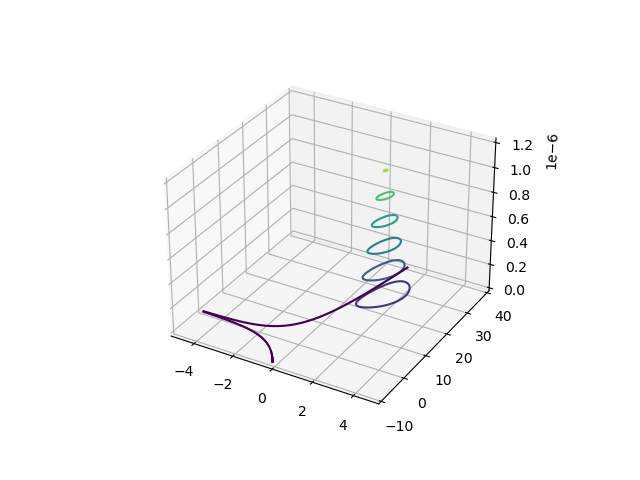

In [37]:
%matplotlib widget
### neal_funnel log_prob plot ###

obs_lp = obs_t

xmin = -5
xmax = 5
ymin = -10
ymax = 40

xs_r, ys_r = torch.meshgrid(torch.linspace(xmin,xmax,1000), torch.linspace(ymin,ymax,1000))

xs = torch.reshape(xs_r, (-1,1,1))
ys = torch.reshape(ys_r, (-1,1,1))


exec_trace = trace(condition(model, {'x': xs, 'y': ys})).get_trace(torch.transpose(torch.tensor([[20,20]]),0,1),noise = 5)

print(exec_trace.format_shapes())

def unnormal_log_prob_nf(tr):
    tr.compute_log_prob()
    nodes = tr.nodes

    prob = 0
    prob += nodes["x"]["log_prob"].sum(1)
    prob += nodes["y"]["log_prob"].sum(1)
    
    prob += nodes["obs"]["log_prob"].sum(1)
    for key,value in nodes.items():
        if value["type"] == "sample":
            print(key)
            print(value["fn"].log_prob(value["value"]).shape)
            print(value["fn"].sample().shape)

    return prob

unnormal_probs = unnormal_log_prob_nf(exec_trace)

for i in range(unnormal_probs.shape[1]):
    lp_r = torch.reshape(unnormal_probs[:,i], xs_r.shape)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.contour(xs_r,ys_r,torch.exp(lp_r))

    print(lp_r[0,0])
    print(xs_r[0,0])

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    plt.show()

    Trace Shapes:              
     Param Sites:              
    Sample Sites:              
  obs_batch plate           1 |
           x dist           1 |
            value 1000000 1 1 |
y_decentered dist 1000000 1 1 |
            value 1000000 1 1 |
    obs_num plate           2 |
         obs dist 1000000 2 1 |
            value         2 1 |
x
(1000000, 1, 1)
(1,)
y_decentered
(1000000, 1, 1)
(1000000, 1, 1)
obs
(1000000, 2, 1)
(1000000, 2, 1)
-47.94858
-5.0


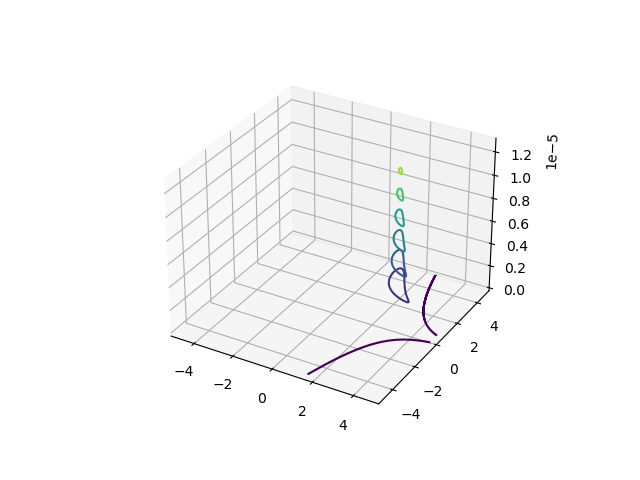

In [45]:
%matplotlib widget
### neal_funnel log_prob plot ###

obs_lp = obs_t

xmin = -5
xmax = 5
ymin = -10
ymax = 40

xs_r, ys_r = torch.meshgrid(torch.linspace(xmin,xmax,1000), torch.linspace(ymin,ymax,1000))

xs = torch.reshape(xs_r, (-1,1,1))
ys = torch.reshape(ys_r, (-1,1,1))

model = reparam(neal_funnel, config={"y": VIPReparam.LocScaleReparam2(0,batch_depth=1)})
exec_trace = trace(condition(model, {'x': xs, 'y_decentered': ys})).get_trace(torch.transpose(torch.tensor([[20,20]]),0,1),noise = 5)

print(exec_trace.format_shapes())

def unnormal_log_prob_nf(tr):
    tr.compute_log_prob()
    nodes = tr.nodes

    prob = 0
    prob += nodes["x"]["log_prob"].sum(1)
    prob += nodes["y_decentered"]["log_prob"].sum(1)
    
    prob += nodes["obs"]["log_prob"].sum(1)
    for key,value in nodes.items():
        if value["type"] == "sample":
            print(key)
            print(value["fn"].log_prob(value["value"]).shape)
            print(value["fn"].sample().shape)

    return prob

unnormal_probs = unnormal_log_prob_nf(exec_trace)

for i in range(unnormal_probs.shape[1]):
    lp_r = torch.reshape(unnormal_probs[:,i], xs_r.shape)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.contour(xs_r,ys_r,torch.exp(lp_r))

    print(lp_r[0,0])
    print(xs_r[0,0])

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    plt.show()

In [48]:
reparam_model = reparam(neal_funnel, config={"y": VIPReparam.LocScaleReparam2(0.8,batch_depth=1)})

nuts_kernel2 = NUTS(reparam_model)

mcmc2 = MCMC(nuts_kernel2, num_warmup=100, num_samples=500 ,num_chains=1)

rng_key2 = random.PRNGKey(0)

mcmc2.run(rng_key2, jnp.transpose(jnp.array([[20,20]])), noise=5, extra_fields=('num_steps',))


mcmc2.print_summary()

sample: 100%|██████████| 600/600 [00:02<00:00, 219.92it/s, 7 steps of size 5.44e-01. acc. prob=0.96]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
           x[0]      2.39      0.42      2.39      1.72      3.11    252.50      1.00
y_decentered[0]     10.92      2.14     10.93      7.54     14.72    230.70      1.00

Number of divergences: 0


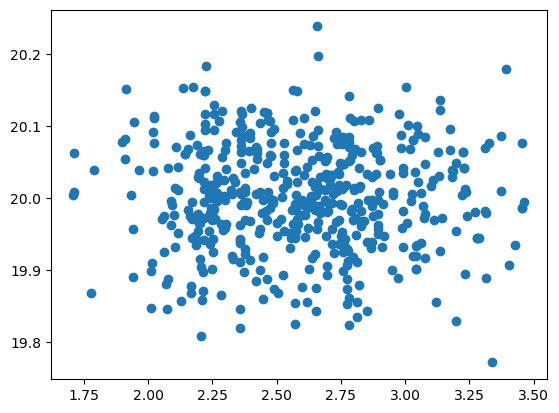

In [22]:
smps = mcmc2.get_samples()
plt.scatter(smps["x"],smps["y"])

In [28]:
from importlib import reload
reload(VIPReparam)
import VIPReparam

noises = jnp.linspace(0.5,5,10)
#noises = (0.1,)
vip_list = []

for noise in noises:
    optimizer = Adam(step_size = 0.1)

    learnable_model = reparam(neal_funnel, config={"y": VIPReparam.LocScaleReparam2(batch_depth=1)})

    # setup the inference algorithm
    svi = SVI(learnable_model, AutoNormal(learnable_model), optimizer, loss=Trace_ELBO())

    # do gradient steps
    svi_result = svi.run(random.PRNGKey(100), 20000, jnp.array(obs_f),noise)
    vip_list.append(jnp.copy(svi_result.params["y_centered"]))




100%|██████████| 20000/20000 [00:12<00:00, 1584.12it/s, init loss: 6662.5361, avg. loss [19001-20000]: 4155.2793]


In [25]:
from importlib import reload
reload(VIPReparam)
import VIPReparam

noises = jnp.linspace(0.5,5,10)
#noises = (5,)
vip_list = []

for noise in noises:
    optimizer = Adam(step_size = 0.1)

    learnable_model = reparam(neal_funnel, config={"y": VIPReparam.LocScaleReparam2(batch_depth=1)})

    # setup the inference algorithm
    svi = SVI(learnable_model, AutoNormal(learnable_model), optimizer, loss=Trace_ELBO())

    # do gradient steps
    svi_result = svi.run(random.PRNGKey(100), 20000, jnp.transpose(jnp.array([[20,20]])),noise)
    vip_list.append(jnp.copy(svi_result.params["y_centered"]))




100%|██████████| 20000/20000 [00:11<00:00, 1696.74it/s, init loss: 31.4689, avg. loss [19001-20000]: 11.6866]


In [6]:
print(vip_list)

[DeviceArray([0.90138096], dtype=float32)]


0 0.5 0.5


NameError: name 'obs' is not defined

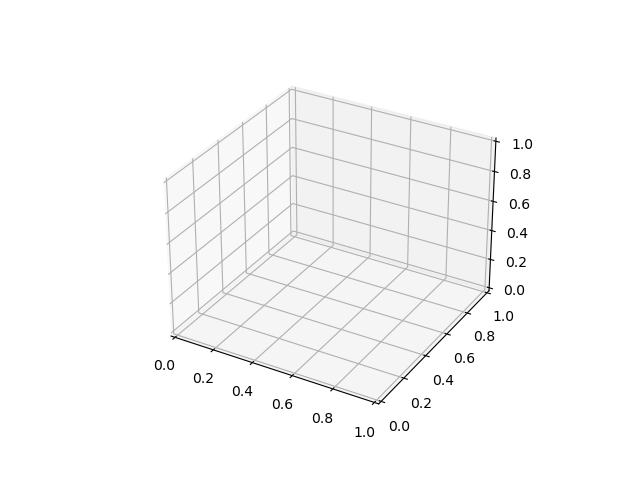

In [26]:
%matplotlib widget
import matplotlib.pyplot as plt
plt.clf()
ax = plt.subplot(projection="3d")
for i,vips in enumerate(vip_list):

    print(i, noises[i], str(noises[i]))
    #ax.plot(obs_f[0,:],vips,label=str(noises[i]))
    #if i == 9:
    surf = ax.plot_surface(obs[...,0],obs[...,1],jnp.reshape(vips,(20,20)))
    #fake2Dline = plt.Line2D([0],[0], linestyle="none", c=surf._facecolors3d, marker = 'o',label=str(noises[i]))
plt.show()